# Learning diffusion with a neural partial differential equation

In [2]:
using LinearAlgebra

using DifferentialEquations
using Flux
using DiffEqFlux

using Plots
default(fmt = :png)

We want to solve the heat (or diffusion) equation

$$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}, \quad x \in \left[-\frac{1}{2}, \frac{1}{2}\right], \quad x\left(-\frac{1}{2}\right) = x\left(\frac{1}{2}\right)$$

Let's go with $N = 16$ grid points and $\kappa = 1$.

In [3]:
N = 16
L = 1
Δx = L / N
κ = 1

x = range(-L/2, L/2, length=N)

-0.5:0.06666666666666667:0.5

Discretizing the spatial derivative with a second-order centered finite-difference

$$\frac{\partial u_i}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2} \approx \kappa \frac{u_{i-1} - 2u_i + u_{i+1}}{\Delta x^2}$$

we get a system of $N$ coupled ODEs which can be described as

$$ \frac{\partial u}{\partial t} = Au $$

where $A$ is a matrix.

In [4]:
function diffusion!(∂u∂t, u, p, t)
    N, Δx, κ = p.N, p.Δx, p.κ
    @inbounds begin
        ∂u∂t[1] = κ * (u[N] -2u[1] + u[2]) / Δx
        for i in 2:N-1
            ∂u∂t[i] = κ * (u[i-1] -2u[i] + u[i+1]) / Δx
        end
        ∂u∂t[N] = κ * (u[N-1] -2u[N] + u[1]) / Δx
    end
    return 
end

diffusion! (generic function with 1 method)

Let's generate an initial condition

$$ u_0(x) = e^{-100x^2} $$

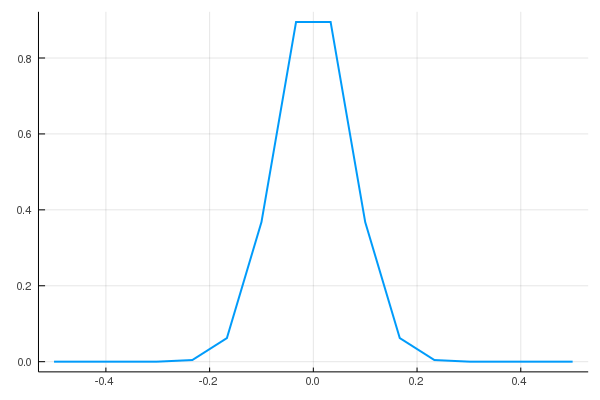

In [5]:
u₀ = @. exp(-100*x^2)

plot(x, u₀, linewidth=2, label="")

We'll pick 30 equally spaced times between $t = 0$ and $t = 0.1$ to save the state of the PDE.

In [45]:
tspan = (0.0, 0.1)
Nt_data = 30
Δt_data = (tspan[2] - tspan[1]) / Nt_data
t = range(tspan[1], tspan[2], length=Nt_data)

0.0:0.0034482758620689655:0.1

Set up and solve the PDE.

In [59]:
params = (N=N, Δx=Δx, κ=κ)
prob = ODEProblem(diffusion!, u₀, tspan, params)
sol = solve(prob, Tsit5(), saveat=t);

In [71]:
uₙ    = zeros(N, Nt_data-1)
uₙ₊₁  = zeros(N, Nt_data-1)

for i in 1:Nt_data-1
       uₙ[:, i] .=  sol.u[i]
     uₙ₊₁[:, i] .=  sol.u[i+1]
end

training_data = [(uₙ[:, i], uₙ₊₁[:, i]) for i in 1:Nt_data-1];

Let's plot the solution

┌ Info: Saved animation to 
│   fn = /home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusing_gaussian.gif
└ @ Plots /home/alir/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusing_gaussian.gif")
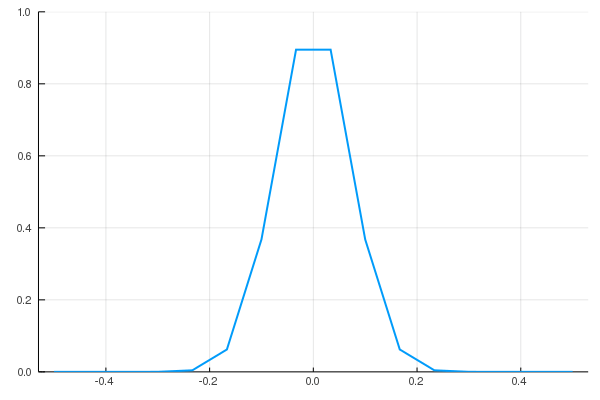

In [27]:
anim = @animate for n=1:Nt
    plot(x, data[:, n], linewidth=2, ylim=(0, 1), label="", show=false)
end

gif(anim, "diffusing_gaussian.gif", fps=15)

Now let's create a two-layer neural network to see if we can learn diffusion

In [140]:
dudt_NN = Chain(Dense(N, 100, tanh),
                Dense(100, N))

ps = Flux.params(dudt_NN);

Set up a neural PDE that solves the system of ODEs described by

$$ \frac{\partial u}{\partial t} = \text{NN}(u) $$

In [141]:
tspan_npde = (0.0, Δt_data)
diffusion_npde = NeuralODE(dudt_NN, tspan_npde, Tsit5(), reltol=1e-4, save_start=false, save_end=true);

Define the loss/objective function to be

$$ \left| u(x, t) - u_{NN}(x, t) \right|^2 \approx \sum_{n=1}^{N_t} \sum_{i=1}^{N_x} \left| u_i^n - (u_{NN})_i^n \right|^2 $$

In [142]:
loss_function(uₙ, uₙ₊₁) = sum(abs2, uₙ₊₁ .- diffusion_npde(uₙ))

loss_function (generic function with 1 method)

Use the Adam optimization algorithm (adaptive moment estimation?). Seems to be recommended as a good default.

In [143]:
opt = ADAM(1e-3)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

Define a callback function to observe training in progress and stop once loss is acceptable.

In [144]:
function cb()
    train_loss = sum([loss_function(training_data[i]...) for i in 1:Nt_data-1])
    println("train_loss = $train_loss")    
    return train_loss
end

cb();

train_loss = 0.017014852792533324


Training!

In [145]:
Flux.train!(loss_function, ps, training_data, opt, cb=cb)

train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324
train_loss = 0.017014852792533324


Let's see how well it fit the training data.

┌ Info: Saved animation to 
│   fn = /home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusion_neural_pde_gaussian.gif
└ @ Plots /home/alir/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusion_neural_pde_gaussian.gif")
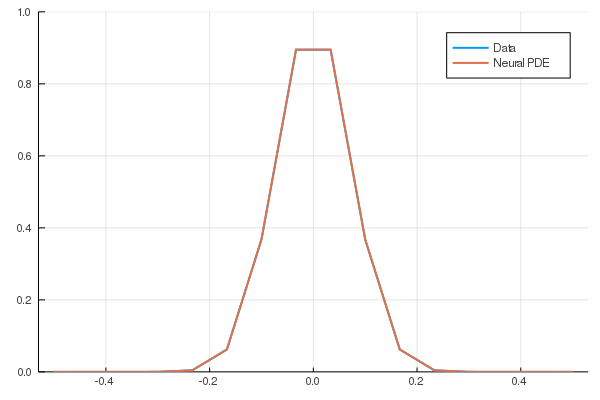

In [146]:
u_NN = zeros(N, Nt_data)
u_NN[:, 1] .= u₀
for n in 2:Nt_data
    sol = diffusion_npde(u_NN[:, n-1])
    u_NN[:, n] .= sol.u[1]
end

anim = @animate for n=1:Nt_data-1
    plot(x, uₙ[:, n],    linewidth=2, ylim=(0, 1), label="Data", show=false)
    plot!(x, u_NN[:, n], linewidth=2, ylim=(0, 1), label="Neural PDE", show=false)
end
gif(anim, "diffusion_neural_pde_gaussian.gif", fps=15)

Let's see how well it fits

$$ u_0(x) = 1 - cos(2\pi x) $$

┌ Info: Saved animation to 
│   fn = /home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusion_neural_pde_cosine.gif
└ @ Plots /home/alir/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/home/alir/neural-differential-equation-climate-parameterizations/diffusion_equation/diffusion_neural_pde_cosine.gif")
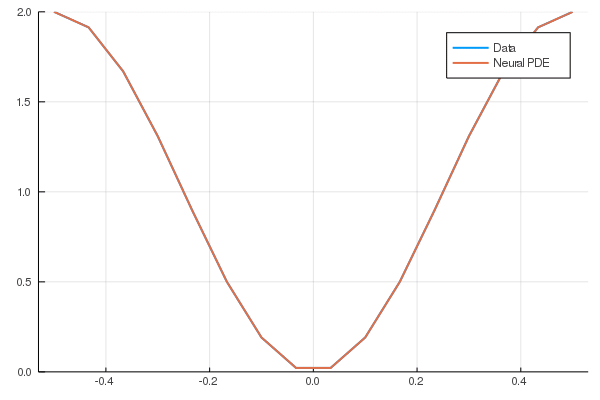

In [139]:
u₀_cos = @. 1 - cos(2π * x)

prob = ODEProblem(diffusion!, u₀_cos, tspan, params)
ode_data = Array(solve(prob, Tsit5(), saveat=t))

u_NN = zeros(N, Nt_data)
u_NN[:, 1] .= u₀_cos
for n in 2:Nt_data
    sol = diffusion_npde(u_NN[:, n-1])
    u_NN[:, n] .= sol.u[1]
end

anim = @animate for n=1:Nt_data-1
    plot(x, ode_data[:, n], linewidth=2, ylim=(0, 2), label="Data", show=false)
    plot!(x, u_NN[:, n], linewidth=2, ylim=(0, 2), label="Neural PDE", show=false)
end
gif(anim, "diffusion_neural_pde_cosine.gif", fps=15)